In [192]:
import numpy
import matplotlib.pyplot as plt
import os
import scipy as sp
import math

SAMPLEFREQ = 44100
FREQUENCIES = numpy.fft.fftfreq(SAMPLEFREQ, d=1/SAMPLEFREQ)

running
done


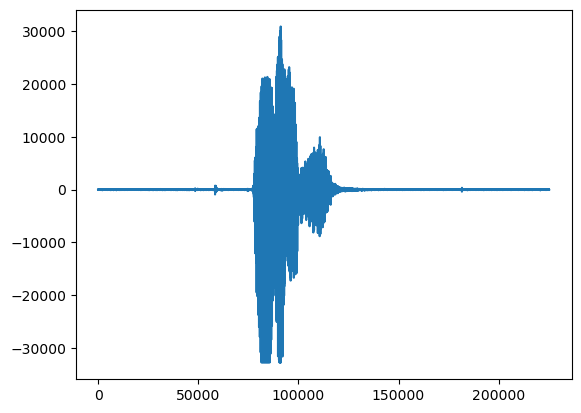

/tmp/ipykernel_589/3590330286.py:2: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  gauss_window = numpy.array(sp.signal.gaussian(512, std=4))


{'hoch': 0.802371980889814,
 'tief': 0.7915254271131817,
 'links': 0.7732829151857988,
 'rechts': 0.781424712112684}

In [202]:
import pyaudio


def aufnahme():
    FORMAT = pyaudio.paInt16
    FRAMESIZE = 1024
    NOFFRAMES = 220
    p = pyaudio.PyAudio()
    print("running")
    stream = p.open(format=FORMAT,channels=1,rate=SAMPLEFREQ,
    input=True,frames_per_buffer=FRAMESIZE)
    data = stream.read(NOFFRAMES*FRAMESIZE)
    decoded = numpy.frombuffer(data,dtype=numpy.int16);
    stream.stop_stream()
    stream.close()
    p.terminate()
    print("done")
    numpy.save("./file",decoded)
    plt.plot(decoded)
    plt.show()
# aufnahme()
# Spracherkenner("./file.npy")

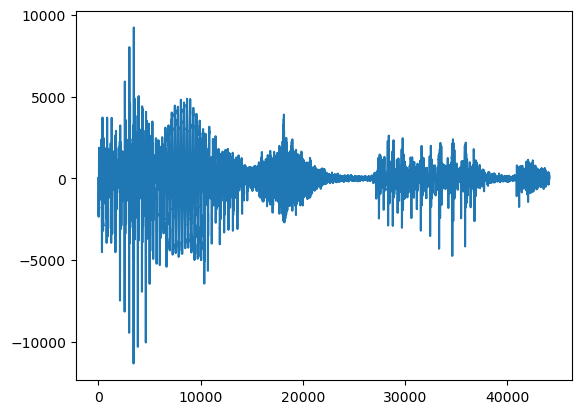

In [194]:

def trigger(path, threshold=1200,skipheader=0):
    sample = numpy.load(path)
    x = []
    for i in range(skipheader,len(sample)):
        if sample[i] >= threshold:
            for j in range(i,len(sample)):
                if(-100<=sample[j]<=100):
                    i=j
                    break
            x = sample[i:]
            break
    return x[0:SAMPLEFREQ]


test = trigger("./file.npy",2500)
plt.plot(test)

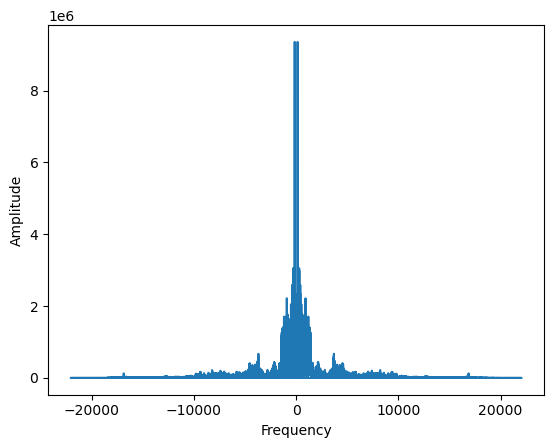

In [195]:

def calculate_amplitude_spectrum(signal):
    n = len(signal)
    spectrum = numpy.fft.fft(signal)
    amplitude_spectrum = numpy.abs(spectrum)
    return amplitude_spectrum

amplitude_spectrum = calculate_amplitude_spectrum(test)
plt.plot(FREQUENCIES, amplitude_spectrum)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()


Aufgabe1 (d) Das mittels Windowing erhaltene Spektrum ist geglättet und hat eine reduzierte Auflösung.

/tmp/ipykernel_589/3590330286.py:2: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  gauss_window = numpy.array(sp.signal.gaussian(512, std=4))


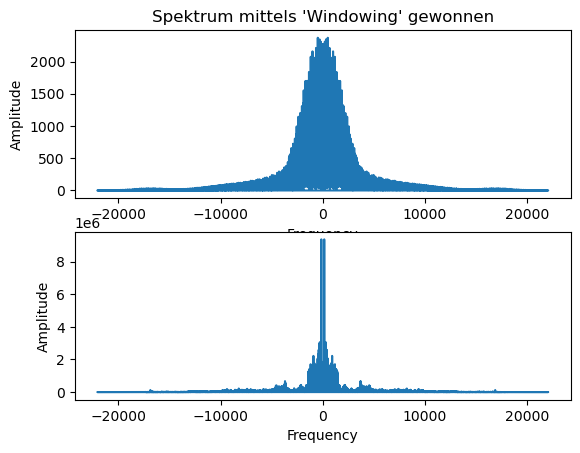

In [196]:
def cutInWindows(signal, window_size=512):
    gauss_window = numpy.array(sp.signal.gaussian(512, std=4))
    retlist = []

    # halbes Überlappen über Schrittweite erledigt
    for i in range(0, len(signal) - window_size + 1, math.floor(window_size / 2)):
        retlist.append(numpy.concatenate( [[0] * i, gauss_window * (signal[i:i + window_size]), [0] * (len(signal) - (i + window_size))] ))
    return retlist

def fft_with_windows(signal):
    n = len(signal)
    tmp = numpy.array(cutInWindows(signal))
    spectrum = numpy.fft.fft(tmp).mean(0)
    amplitude_spectrum = numpy.abs(spectrum)
    return  amplitude_spectrum
    

plt.subplot(2, 1, 1)
a_spec = fft_with_windows(test)
plt.plot(FREQUENCIES, a_spec)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title("Spektrum mittels 'Windowing' gewonnen")

plt.subplot(2, 1, 2)
plt.plot(FREQUENCIES, amplitude_spectrum)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()

Aufgabe 2.1

/tmp/ipykernel_589/3590330286.py:2: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  gauss_window = numpy.array(sp.signal.gaussian(512, std=4))


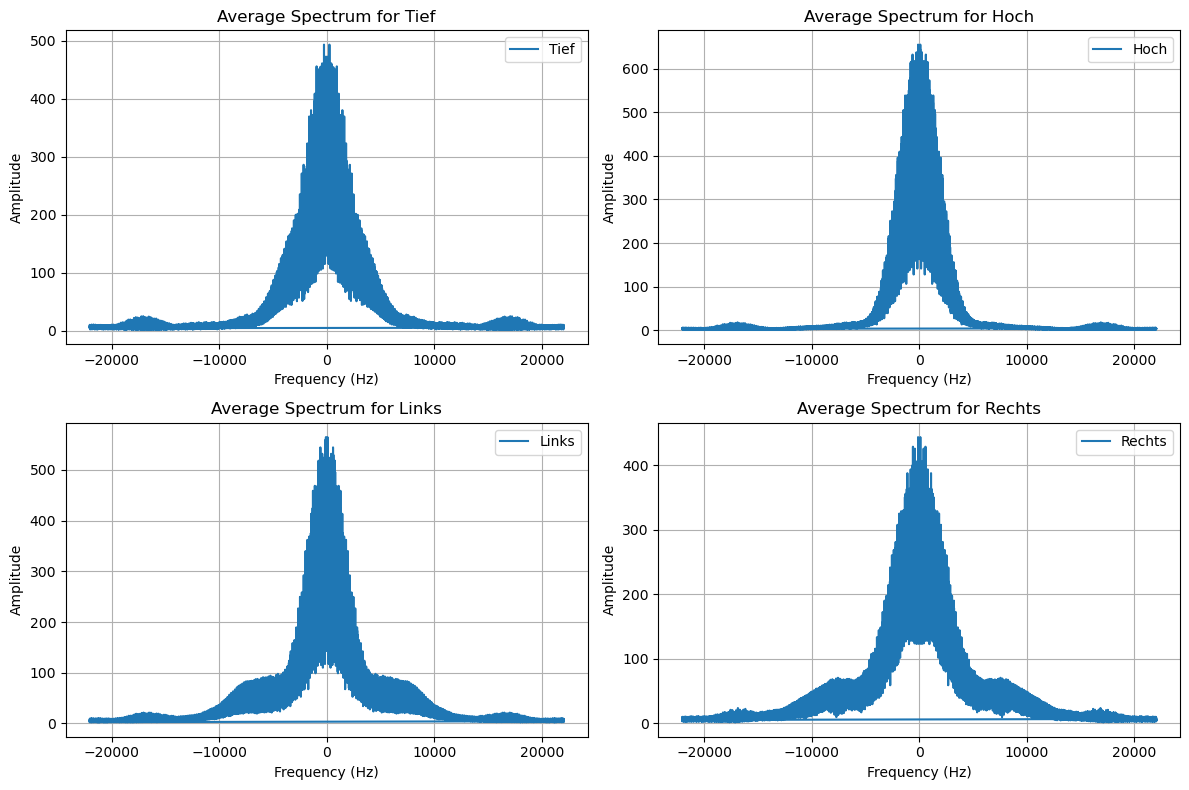

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


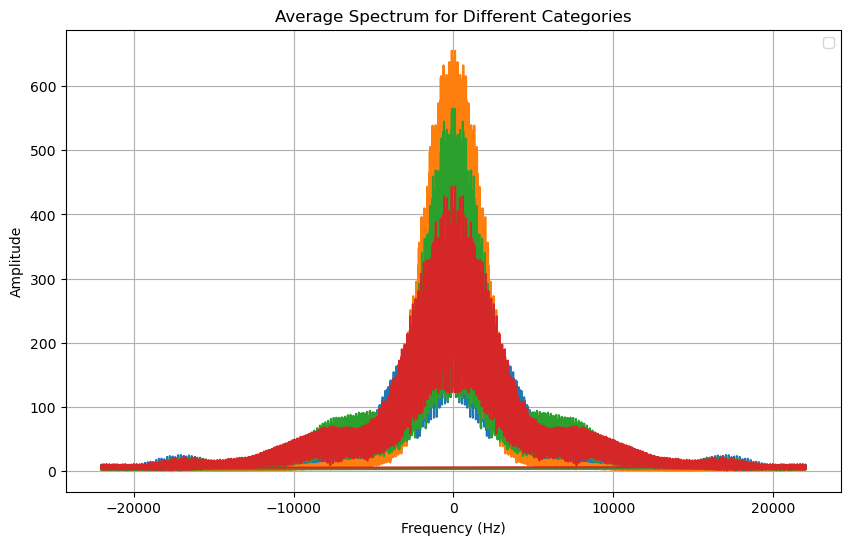

In [197]:
folder_path = "./training/"

rauschen=1200

tief_arrays = {f"tief{i}":trigger(os.path.join(folder_path, f"tief{i}.npy"),rauschen) for i in range(5)}
hoch_arrays = {f"hoch{i}":trigger(os.path.join(folder_path, f"hoch{i}.npy"),rauschen) for i in range(5)}
links_arrays = {f"links{i}":trigger(os.path.join(folder_path, f"links{i}.npy"),rauschen) for i in range(5)}

rechts_arrays = {f"rechts{i}":trigger(os.path.join(folder_path, f"rechts{i}.npy"),rauschen) for i in range(5)}

def plot_average_spectrum(category, arrays, ax=None):
    average_spectrum = numpy.mean([fft_with_windows(arr) for arr in arrays.values()], axis=0)
    ax.plot(FREQUENCIES, average_spectrum, label=category)
    ax.set_title(f'Average Spectrum for {category}')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Amplitude')
    ax.legend()
    ax.grid(True)
    return average_spectrum


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

avTief=plot_average_spectrum('Tief', tief_arrays, ax=axes[0, 0])
avHoch=plot_average_spectrum('Hoch', hoch_arrays, ax=axes[0, 1])
avLinks=plot_average_spectrum('Links', links_arrays, ax=axes[1, 0])
avRechts=plot_average_spectrum('Rechts', rechts_arrays, ax=axes[1, 1])

plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))

plt.plot(FREQUENCIES,avTief)
plt.plot(FREQUENCIES,avHoch)
plt.plot(FREQUENCIES,avLinks)
plt.plot(FREQUENCIES,avRechts)


plt.title('Average Spectrum for Different Categories')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()


In [198]:
def correlationCoef(spectrumX,spectrumY):
    Sx=numpy.std(spectrumX,dtype=numpy.float64)
    Sy=numpy.std(spectrumY,dtype=numpy.float64)
    X_=numpy.mean(spectrumX,dtype=numpy.float64)
    Y_=numpy.mean(spectrumY,dtype=numpy.float64)    
    Variants=[(x - X_) * (y - Y_) for x, y in zip(spectrumX, spectrumY)]
    Covariance=sum(Variants)/(len(Variants)-1)
    return Covariance/(Sx*Sy)

Command={"hoch":avHoch,"tief":avTief,"links":avLinks,"rechts":avRechts}

def Spracherkenner(path):
    input=fft_with_windows(trigger(path))
    coefs={key:correlationCoef(input,Command[key])for key in Command};
    # plt.plot(coefs.keys(),coefs.values())
    # plt.title(path.replace("./test/",""))
    # plt.show()
    return coefs
Successes=0
for com in Command:
    for i in range(5):
        x=Spracherkenner(f"./julian_test/{com}{i}.npy")
        maxi=max(x,key=x.get)
        if(maxi==com):
            Successes+=1
        else:
            print(maxi+" for "+com+str(i))
    print("------------"+com+"-tested--------------")
print("Correct= "+str(Successes)+" Errorrate= "+str((20-Successes)*5)+"%")

/tmp/ipykernel_589/3590330286.py:2: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  gauss_window = numpy.array(sp.signal.gaussian(512, std=4))


tief for hoch1
tief for hoch4
------------hoch-tested--------------
rechts for tief0
hoch for tief1
links for tief4
------------tief-tested--------------
rechts for links1
tief for links2
hoch for links3
------------links-tested--------------
------------rechts-tested--------------
Correct= 12 Errorrate= 40%


### OriginalSprecher
Correct= 11 Errorrate= 45%
### ZweitSprecher
Correct= 12 Errorrate= 40%

samplesize=20